In [1]:
import sys

sys.path.insert(0, "..")
from src.settings import StyleSettings
from src.data.data_tools import StyleDataset
import numpy as np
import seaborn as sns


# Load the data

In [2]:
settings = StyleSettings()
traindataset = StyleDataset([settings.trainpath])
testdataset = StyleDataset([settings.testpath])


We have 419 batches in the dataset

In [3]:
len(traindataset) // 32


419

In [4]:
x, y = traindataset[42]
x, y


('Lace is an openwork fabric , patterned with open holes in the work , made by machine or by hand.',
 'wiki')

Every batch is a `Tuple[str, str]` of a sentence and a label. We can see this is a classification task.
The task is, to classify sentences in four categories.
Lets build a vocabulary by copy-pasting the code we used before

In [5]:
from src.models import tokenizer

corpus = []
for i in range(len(traindataset)):
    x = tokenizer.clean(traindataset[i][0])
    corpus.append(x)
v = tokenizer.build_vocab(corpus, max=20000)
len(v)


2022-07-05 18:23:48.534 | INFO     | src.models.tokenizer:build_vocab:27 - Found 19306 tokens


19308

We need to cast the labels to an integers. You can use this dictionary to do so:

In [6]:
d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
d[y]


2

# Question 1
Figure out, for every class, what accuracy you should expect if the model would guess blind on the train set

In [7]:
# TODO ~ about 4 lines of code

incorrect = [0,0,0,0]
correct = [0,0,0,0]

for x,y in traindataset:
    if d[y] == np.random.randint(4):
        correct [d[y]] = correct[d[y]] + 1
    else:
        incorrect [d[y]] = incorrect [d[y]] + 1

In [8]:
for Class in d:
    populatie_class = int(correct[d[Class]]) + int(incorrect[d[Class]])
    populatie_perc_totaal = int((populatie_class / len(traindataset))*100)
    accuracy = int(correct[d[Class]] / populatie_class * 100)

    print(f"Class {Class} ({d[Class]})")
    print(f"Accuracy: {accuracy}%") 
    print(f"{correct[d[Class]]} correct van {populatie_class} totaal") 
    print(f"Populatie {populatie_perc_totaal}% van totaal traindataset")
    print("")

Class humor (0)
Accuracy: 25%
1070 correct van 4213 totaal
Populatie 31% van totaal traindataset

Class reuters (1)
Accuracy: 25%
1061 correct van 4186 totaal
Populatie 31% van totaal traindataset

Class wiki (2)
Accuracy: 24%
1037 correct van 4181 totaal
Populatie 31% van totaal traindataset

Class proverbs (3)
Accuracy: 23%
196 correct van 831 totaal
Populatie 6% van totaal traindataset



Reflect on what you see. What does this mean? What implications does this have? Why is that good/bad?
Are there things down the line that could cause a problem?

In [9]:
print("Wat zie ik?")
print("De accuracy is voor alle classes ongeveer gelijk, tussen de 22% en 25%")
print("De classes humor, reuters hen wiki hebben allemaal ongeveer een gelijk deel in de trainingsset, namelijk 31%")
print("Terwijl proverbs significant kleiner is, namelijk 7%")
print("")
print("Wat betekent dat?")
print("Een ongebalanceerde trainset kan er voor zorgen dat je model slecht gaat presteren.")
print("Het kan lijken alsof het model goed presteert, terwijl deze eigenlijk aan het overfitten is.")
print("De class 'proverbs' is maar een klein deel van de totaal trainingset")
print("terwijl dit in werkelijkheid op de testset veel groter deel kan zijn, maar het model is hier niet op getraind")
print("")
print("Hoe kan je het oplossen")
print("bijvoorbeeld:")
print("1. Sampelen van datapunten, zodat de trainset toch nog een gelijke populatie krijgt")
print("2. gewichten toevoegen , bijv. random forest")
print("")
print("Als er geen manier is om het op te lossen, dan is accuracy niet het goede instrument om te meten hoe het model presteert")

Wat zie ik?
De accuracy is voor alle classes ongeveer gelijk, tussen de 22% en 25%
De classes humor, reuters hen wiki hebben allemaal ongeveer een gelijk deel in de trainingsset, namelijk 31%
Terwijl proverbs significant kleiner is, namelijk 7%

Wat betekent dat?
Een ongebalanceerde trainset kan er voor zorgen dat je model slecht gaat presteren.
Het kan lijken alsof het model goed presteert, terwijl deze eigenlijk aan het overfitten is.
De class 'proverbs' is maar een klein deel van de totaal trainingset
terwijl dit in werkelijkheid op de testset veel groter deel kan zijn, maar het model is hier niet op getraind

Hoe kan je het oplossen
bijvoorbeeld:
1. Sampelen van datapunten, zodat de trainset toch nog een gelijke populatie krijgt
2. gewichten toevoegen , bijv. random forest

Als er geen manier is om het op te lossen, dan is accuracy niet het goede instrument om te meten hoe het model presteert


# Question 2 : Implement a preprocessor

We can inherit from `tokenizer.Preprocessor`
Only thing we need to adjust is the `cast_label` function.
 
- create a StylePreprocessor class
- inherit from Preprocessor
- create a new cast_label function for this dataset

In [10]:
# TODO ~ about 4 lines of code
class StylePreprocessor(tokenizer.Preprocessor):
    def cast_label(self, label: str) -> int:
        d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
        label_int = d[label]
        return label_int

To test the preprocessor:

In [11]:
preprocessor = StylePreprocessor(max=100, vocab=v, clean=tokenizer.clean)
x1, y1 = preprocessor([(x, y)])

print("Tekst x :" , x)
print("Label y :", y)
print("Na preprocessing:", x1)
print("Na preprocessing:", y1)

Tekst x : Taylor wins by one shot at Pebble Beach  
Label y : reuters
Na preprocessing: tensor([[4929,  854,   32,   15,  499,   21, 8496,  890]], dtype=torch.int32)
Na preprocessing: tensor([1])


# Set up the model
We can re-use the BaseDatastreamer

In [12]:
from src.data import data_tools

trainstreamer = data_tools.BaseDatastreamer(
    dataset=traindataset, batchsize=32, preprocessor=preprocessor
).stream()
teststreamer = data_tools.BaseDatastreamer(
    dataset=testdataset, batchsize=32, preprocessor=preprocessor
).stream()


In [13]:
x, y = next(trainstreamer)
x.shape, y

(torch.Size([32, 24]),
 tensor([2, 1, 1, 0, 1, 0, 2, 1, 2, 1, 0, 1, 1, 3, 2, 0, 2, 2, 1, 0, 0, 3, 3, 3,
         0, 2, 0, 0, 1, 3, 1, 0]))

## Question 3 : Metrics, loss
Select proper metrics and a loss function.

Bonus: implement an additional metric function that is relevant for this case.

In [33]:
from src.models import metrics
import torch
# TODO ~ 2 lines of code

metrics = [metrics.F1Score(), metrics.Precision(), metrics.Recall()]
loss_fn = torch.nn.CrossEntropyLoss()

#Metrics toegevoegd aan src/models/metrics

## Question 4 : Basemodel
Create a base model. It does not need to be naive; you could re-use the
NLP models we used for the IMDB.

I suggest to start with a hidden size of about 128.
Use a config dictionary, or a gin file, both are fine.

Bonus points if you create a Trax model in src.models, and even more if you add a trax training loop.

In [15]:
log_dir = settings.log_dir
# TODO between 2 and 8 lines of code, depending on your setup
# Assuming you load your model in one line of code from src.models.rnn
#model = None
#--------------------------------------------

from src.models import rnn

config = {
    "vocab": len(v),
    "input_size": 32,
    "hidden_size": 128,
    "num_layers": 3,
    "dropout": 0.1,
    "output_size": 4,
}

model = rnn.NLPmodel(config)

print(model)

NLPmodel(
  (emb): Embedding(19308, 128)
  (rnn): GRU(128, 128, num_layers=3, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=128, out_features=4, bias=True)
)


Set up the trainloop.

- Give the lenght of the traindataset, how many batches of 32 can you get out of it?
- If you take a short amount of train_steps (eg 25) for every epoch, how many epochs do you need to cover the complete dataset?
- What amount of epochs do you need to run the loop with trainsteps=25 to cover the complete traindataset once? 
- answer the questions above, and pick a reasonable epoch lenght

Start with a default learning_rate of 1e-3 and an Adam optimizer.

In [36]:
print("Geef de lengte van de traindataset, hoeveel batches van 32 an je hier uit krijgen?")
print("Lengte traindataset:" , len(traindataset))
print("Dat is aantal batches van 32: " , len(traindataset), "/ 32 =" , len(traindataset)/32 , "=" , int(len(traindataset)/32)+1)
print("")
print("Als je een klein aantal train_steps (bv 25) neemt voor elke epoch, hoeveel epochs moet je nemen om de gehele dataset de tekken?")
print("1 epoch is 1 iteratie van de gehele dataset")
print("Bij train_stept = 25 , dan heb je minimaal " , (int(len(traindataset)/32)+1)/25 , "epochs nodig om de hele trainingset te doorlopen")
print("")
print("Hoeveel epochs moet je hebben om de hele dataset 1 keer door te lopen, met trainsteps=25")
print("17")

print("Keuze voor basemodel aantal epochs = 50")

Geef de lengte van de traindataset, hoeveel batches van 32 an je hier uit krijgen?
Lengte traindataset: 13411
Dat is aantal batches van 32:  13411 / 32 = 419.09375 = 420

Als je een klein aantal train_steps (bv 25) neemt voor elke epoch, hoeveel epochs moet je nemen om de gehele dataset de tekken?
1 epoch is 1 iteratie van de gehele dataset
Bij train_stept = 25 , dan heb je minimaal  16.8 epochs nodig om de hele trainingset te doorlopen

Hoeveel epochs moet je hebben om de hele dataset 1 keer door te lopen, met trainsteps=25
17
Keuze voor basemodel aantal epochs = 50


In [38]:
from src.training import train_model

model = train_model.trainloop(
    epochs=50,
    model=model,
    metrics=metrics,
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)

#log_dir=log_dir,


2022-07-05 20:21:26.387 | INFO     | src.data.data_tools:dir_add_timestamp:68 - Logging to ../tune/20220705-2021
100%|██████████| 25/25 [00:02<00:00, 10.19it/s]
2022-07-05 20:21:29.402 | INFO     | src.training.train_model:trainloop:164 - Epoch 0 train 0.0223 test 0.6520 metric ['0.8061', '0.8149', '0.8494']
100%|██████████| 25/25 [00:02<00:00, 12.48it/s]
2022-07-05 20:21:31.869 | INFO     | src.training.train_model:trainloop:164 - Epoch 1 train 0.0626 test 0.3925 metric ['0.8420', '0.8897', '0.8627']
100%|██████████| 25/25 [00:01<00:00, 13.73it/s]
2022-07-05 20:21:34.080 | INFO     | src.training.train_model:trainloop:164 - Epoch 2 train 0.0332 test 0.4312 metric ['0.8323', '0.8413', '0.8698']
100%|██████████| 25/25 [00:01<00:00, 17.88it/s]
2022-07-05 20:21:35.922 | INFO     | src.training.train_model:trainloop:164 - Epoch 3 train 0.0105 test 0.4208 metric ['0.8082', '0.8331', '0.8765']
100%|██████████| 25/25 [00:01<00:00, 17.97it/s]
2022-07-05 20:21:37.725 | INFO     | src.training.t

Save an image from the training in tensorboard in the `figures` folder.
Explain what you are seeing.

your explanation here

# 5 Evaluate the basemodel
Create a confusion matrix with the code below

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'Target')]

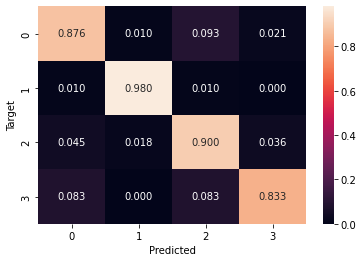

In [39]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for _ in range(10):
    X, y = next(teststreamer)
    yhat = model(X)
    yhat = yhat.argmax(dim=1)
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

#confusion matrix opgeslagen in map 'figures'

Save this in the figures folder.
Interpret this. 

- What is going on?
- What is a good metric here?
- how is your answer to Q1 relevant here?
- Is there something you could do to fix/improve things, after you see these results?

**Antwoord Agnes**

Wat is er aan de hand?

- Class 3 komt er niet goed uit. Waar de andere klasses (0tm2) tussen 0.862 en 0.915 goed voorspellen, komt dit bij klasse 3 op 0,6 en wordt deze ook vaak verward met klasse 2.
- Dit komt door de ongebalanceerde traindataset
- Zie daarvoor ook antwoord vraag 1
- Wat je kan doen om het te verbeteren: Smooth, Oversampling/Undersampling, Metrics wijzigen (geen accuracy)


# 6 Tune the model
Don't overdo this.
More is not better.

Bonus points for things like:
- Attention layers
- Trax architecture including a functioning training loop

Keep it small! It's better to present 2 or 3 sane experiments that are structured and thought trough, than 25 random guesses. You can test more, but select 2 or 3 of the best alternatives you researched, with a rationale why this works better.

Keep it concise; explain:
- what you changed
- why you thought that was a good idea  
- what the impact was (visualise or numeric)
- explain the impact

You dont need to get a perfect score; curiousity driven research that fails is fine.
The insight into what is happening is more important than the quantity.

Keep logs of your settings;
either use gin, or save configs, or both :)
Store images in the `figures` folder.

In [32]:
from src.models import rnn

config = {
    "vocab": len(v),
    "input_size": 32,
    "hidden_size": 128,
    "num_layers": 3,
    "dropout": 0.05,
    "output_size": 4,
}

model = rnn.NLPmodel(config)

from src.training import train_model

model = train_model.trainloop(
    epochs=60,
    model=model,
    metrics=metrics,
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)

2022-07-05 20:12:20.404 | INFO     | src.data.data_tools:dir_add_timestamp:68 - Logging to ../tune/20220705-2012
100%|██████████| 25/25 [00:02<00:00, 10.16it/s]
2022-07-05 20:12:23.572 | INFO     | src.training.train_model:trainloop:164 - Epoch 0 train 1.2950 test 1.2826 metric ['0.1807', '0.7670', '0.2886', '0.3387']
100%|██████████| 25/25 [00:02<00:00, 12.49it/s]
2022-07-05 20:12:26.063 | INFO     | src.training.train_model:trainloop:164 - Epoch 1 train 1.2396 test 1.1817 metric ['0.2985', '0.6368', '0.3681', '0.4150']
100%|██████████| 25/25 [00:01<00:00, 18.03it/s]
2022-07-05 20:12:27.898 | INFO     | src.training.train_model:trainloop:164 - Epoch 2 train 1.1778 test 1.1304 metric ['0.3082', '0.6994', '0.3961', '0.4688']
100%|██████████| 25/25 [00:01<00:00, 17.24it/s]
2022-07-05 20:12:29.742 | INFO     | src.training.train_model:trainloop:164 - Epoch 3 train 1.0592 test 0.9585 metric ['0.3654', '0.7791', '0.4723', '0.5663']
100%|██████████| 25/25 [00:01<00:00, 17.71it/s]
2022-07-05 

Ik heb het model op verschillende manier getuned en vastgesteld dat de volgende setup het beste werkt (op de waarden die ik getest heb):

epochs = 60
optimizer = Adam
learing_rate = 1e-3
drop_out = 0.05

De bevindingen en grafieken zijn te vinden onder 'figures'
De tunelogs zijn te vinden onder 'logs'